## 5. Feature Importance and Feature Permutation Importance
In this notebook we are looking at the feature importances  as well as the Permutation feature importances
for the Random Forest Regressor.
We are exemplary considering windfarm 1 in this notebook.

In [21]:
# load modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from modeling.features import get_feature_combinations
from modeling.functions import train_test_split_features
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import ast
import pickle
sns.set_theme()
RSEED = 42

In [3]:
# loading the dataset
data = pd.read_csv('../data/GEFCom2014Data/Wind/clean_data.csv', 
                    parse_dates= ['TIMESTAMP'],
                    index_col= 'TIMESTAMP' )

In [4]:
# train-test-split and get features
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00']

/tmp/ipykernel_5985/2454714424.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data_test = data['2013-07-01 01:00:00']


In [7]:
# windfarm 1
zone = 1

### Feature importance

In [9]:
# Fitting the regressor
df_zone =data_train[data_train['ZONEID']==zone]
X = df_zone.drop(['TARGETVAR', 'ZONEID'], axis=1)
y = df_zone.TARGETVAR
forest = RandomForestRegressor(random_state=RSEED)
forest.fit(X, y)

# importances
importances = forest.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]

Plotting the feauture importances for windfarm 1

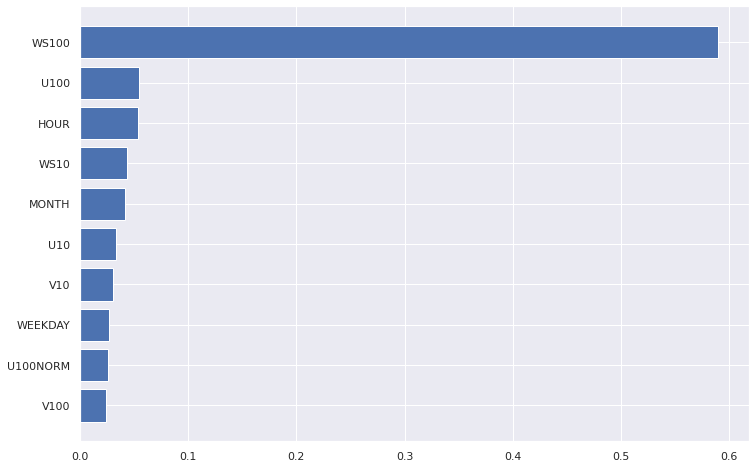

In [159]:
f, ax = plt.subplots(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()


### Feature Permutation Importance
Feature Permutation Importance is a method to measure the importances of a features, based on ranking them by their
effect in the model's prediction score. The idea is to randomly shuffle the column of the feature to be tested, while keeping
the other features unchanged. Then compare the scores of the model, with the shuffled and unshuffled feature. If the feature is
important, the score should decrease after shuffling.

In [16]:
rfr = RandomForestRegressor()
df_model = pd.read_csv(f'../results/RandomForestRegressor.csv')

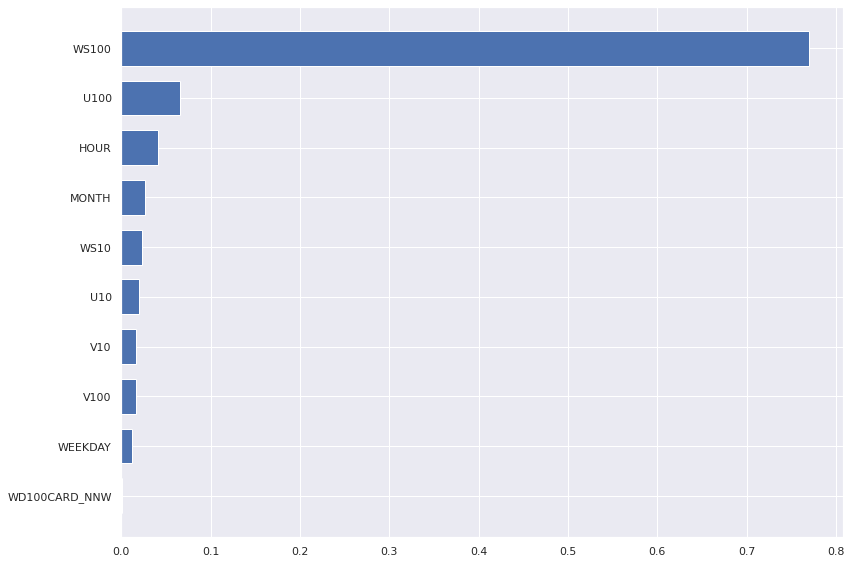

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

#obtain hyperparameters
best_params = df_model[df_model.ZONE == 'ZONE{}'.format(str(zone))]['BEST_PARAMS'].values[0]

# obtain features from the current feature combination
fc = df_model[df_model.ZONE == 'ZONE{}'.format(str(zone))]['FC'].values[0]

# obtain data frame for zone
data_train_zone = data_train[data_train.ZONEID == zone]
data_test_zone = data_test[data_test.ZONEID == zone]

# split in X and y
features = get_feature_combinations()[fc]
X_train, X_test, y_train, y_test = train_test_split_features(data_train, data_test, zone, features)    

# load the model for windfarm 1
rfr = pickle.load(open('../models/model{}.pkl'.format(zone), 'rb'))

# permutation importances
r = permutation_importance(rfr, X_train, y_train, n_repeats=5, random_state=RSEED)            

tree_importance_sorted_idx = np.argsort(rfr.feature_importances_)[-10:]
tree_indices = np.arange(0, 10) + 0.5

# plot the importances
ax1.barh(tree_indices ,rfr.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
fig.tight_layout()
plt.show();

The feature combination we used for our model for windfarm 1 (notebook ```4_Modeling```):

In [19]:
print(fc)

no_deg_norm


In [24]:
print(get_feature_combinations()[fc])

['U10', 'V10', 'U100', 'V100', 'HOUR', 'MONTH', 'WEEKDAY', 'IS_HOLIDAY', 'WS10', 'WS100', 'WD100CARD_ENE', 'WD100CARD_ESE', 'WD100CARD_N', 'WD100CARD_NE', 'WD100CARD_NNE', 'WD100CARD_NNW', 'WD100CARD_NW', 'WD100CARD_S', 'WD100CARD_SE', 'WD100CARD_SSE', 'WD100CARD_SSW', 'WD100CARD_SW', 'WD100CARD_W', 'WD100CARD_WNW', 'WD100CARD_WSW', 'WD10CARD_ENE', 'WD10CARD_ESE', 'WD10CARD_N', 'WD10CARD_NE', 'WD10CARD_NNE', 'WD10CARD_NNW', 'WD10CARD_NW', 'WD10CARD_S', 'WD10CARD_SE', 'WD10CARD_SSE', 'WD10CARD_SSW', 'WD10CARD_SW', 'WD10CARD_W', 'WD10CARD_WNW', 'WD10CARD_WSW']


The Feature Permutation Importance shows once again what an important feature the windspeed at height 100m above ground is, but also that
features like ```hour```, ```month``` or ```weekday``` have some importance, too. As well as the zonal and meridional wind
components.